In [1]:
## IMPORTANT ##

## This notebook assumes a folder /graph/embeddings with the naming convention {dataset}.pt

import sys
import os
import os.path as path
import time

import numpy as np
import torch
from torch import functional as F
from torch_geometric.nn import VGAE

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(path.dirname(path.dirname(path.abspath(os.getcwd()))))
from graph.utils import *
from graph.modules import create_encoder, create_decoder


######## REPLACE PARAMETERS YOU WANT TO TEST HERE ###############

dset = 'CiteSeer'
dist = 'cosine'
percentiles = np.linspace(0.5, 1.0, endpoint=False)

#################################################################

assert dset in ["PubMed", "Cora", "CiteSeer", "Coauthor"]
assert dist in ['dot', 'cosine']
sample = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset, data = load_data(dset)
encoder = create_encoder('VGAE', dataset.num_features, 16).to(device)
decoder = create_decoder(dist, False).to(device)
model = VGAE(encoder=encoder, decoder=decoder).to(device)

Loading data set CiteSeer from:  /nfs/homedirs/ursulean/project-4/graph/../data/CiteSeer


In [2]:
embeddings_folder = path.join(path.dirname(path.abspath(os.getcwd())), 'embeddings')

# Split edges of a torch_geometric.data.Data object into pos negative train/val/test edges
# default ratios of positive edges: val_ratio=0.05, test_ratio=0.1
data.train_mask = data.val_mask = data.test_mask = data.y = None
print("Data.edge_index.size", data.edge_index.size(1))
data = model.split_edges(data)
node_features, train_pos_edge_index = data.x.to(device), data.train_pos_edge_index.to(device)

Data.edge_index.size 9104


In [3]:
# Define only encoder
embeddings = torch.load(path.join(embeddings_folder, dset + "_" + dist + ".pt"), device)
N, D = embeddings.shape

In [4]:
def sample_graph(z, sample_size):
    N, D = z.shape

    sample_size = min(sample_size, N)
    sample_ix = np.random.choice(np.arange(N), size=sample_size, replace=False)

    # Returns the sampled embeddings, and a mapping from their indices to the originals
    return z[sample_ix], {i:sample_ix[i] for i in np.arange(sample_size)}

def test_naive_graph(z, percentiles, sample_size=1000):

    z_sample, index_mapping = sample_graph(z, sample_size)
    t = time.time()
    adjacency = model.decoder.forward_all(z_sample, sigmoid=(dist == 'dot'))

    min_sim_absolute_values, _ = sample_percentile(percentiles, adjacency, dist_measure=dist, sample_size=sample_size)
        
    precisions = []
    recalls = []
    
    for min_sim in min_sim_absolute_values:
        precision, recall = sampled_dense_precision_recall(data, adjacency, index_mapping, min_sim, verbose=False)
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

precisions, recalls = test_naive_graph(embeddings, percentiles)

# for i in range(len(percentiles)):
#     print("Distance percentile {}, precision {}, recall {}".format(percentiles[i], precisions[i], recalls[i]))

# Precision and recall plotted by distance, same scale

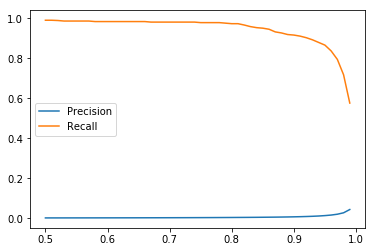

In [5]:
plt.plot(percentiles, precisions)
plt.plot(percentiles, recalls)
plt.legend(["Precision", "Recall"])
plt.show()

# Precision and recall plotted by distance, different scales

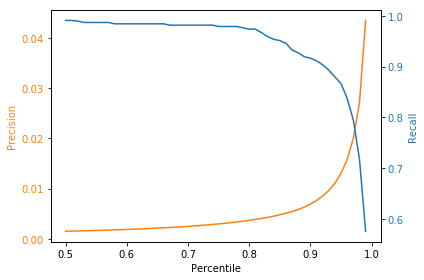

In [6]:
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Percentile')
ax1.set_ylabel('Precision', color=color)
ax1.plot(percentiles, precisions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Recall', color=color)  # we already handled the x-label with ax1
ax2.plot(percentiles, recalls, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()